# Loop Workflow Example 1

> * High level approach to making a 3D model from just a bounding box (in Australia only for now).

In [1]:
import time
t0 = time.time()

## Map2Loop

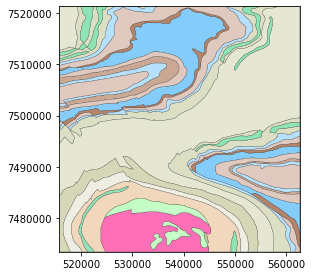

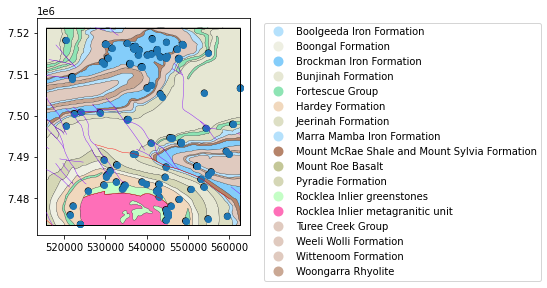

In [2]:
import os
from map2loop.project import Project

proj = Project( 
    loopdata_state="WA",
)

proj.update_config(
                    out_dir='./gmd-model',
                    overwrite='in-place',
                    bbox_3d={
                         "minx": 515687.31005864, # region of interest for GMD paper
                         "miny": 7473446.76593407,
                         "maxx": 562666.860106543,
                         "maxy": 7521273.57407786,
                         "base": -3200,
                         "top": 1200,
                     },
                    proj_crs={'init': 'EPSG:28350'},
                    quiet='all',
                  )

In [3]:
proj.config.c_l['intrusive']='banana'
proj.run()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.66it/s]


## Loop Structural

In [4]:
# Define project pathing from m2l
proj_path = proj.config.project_path
graph_path = proj.config.graph_path
tmp_path = proj.config.tmp_path
data_path = proj.config.data_path
dtm_path = proj.config.dtm_path
output_path = proj.config.output_path
vtk_path = proj.config.vtk_path

# Define project bounds
minx,miny,maxx,maxy = proj.config.bbox
model_base = proj.config.bbox_3d['base']
model_top = proj.config.bbox_3d['top']

fault_file = proj.config.fault_file_csv

In [5]:
from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer
from datetime import datetime
import os
import time
from datetime import datetime
import shutil
import logging
logging.getLogger().setLevel(logging.ERROR)
import lavavu
import numpy as np

t1a = time.time()

nowtime=datetime.now().isoformat(timespec='minutes')   
model_name='leaflet'+'_'+nowtime.replace(":","-").replace("T","-")
if (os.path.exists(vtk_path+model_name)):
    shutil.rmtree(vtk_path+model_name)
os.mkdir(vtk_path+model_name)
filename=vtk_path+model_name+'/'+'surface_name_{}.vtk'


f=open(tmp_path+'/bbox.csv','w')
f.write('minx,miny,maxx,maxy,lower,upper\n')
ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
f.write(ostr)
f.close()


fault_params = {'interpolatortype':'FDI',
                 'nelements':1e5,
#                 'element_volume':3000**3,
                'step':10,
                'fault_buffer':0.3,
#                 'force_mesh_geometry':True,
                'solver':'cg',
#                 overprints:overprints,
                'cpw':10,
                'npw':10}
foliation_params = {'interpolatortype':'FDI' , # 'interpolatortype':'PLI',
                    'nelements':1e5,  # how many tetras/voxels
                    'buffer':1.8,  # how much to extend nterpolation around box
                    'solver':'cg',
#                     'damp':True
                    'cpw':10,
                    'npw':10}
model, m2l_data = GeologicalModel.from_map2loop_directory(proj_path,
                                                          #    evaluate=False,
                                                          fault_params=fault_params,
                                                          rescale=False,
                                                          foliation_params=foliation_params,
                                                         skip_features=['Fault_16245'])
#model.to_file(output_path + "/model.pickle")    

view = LavaVuModelViewer(model,vertical_exaggeration=1) 
view.nsteps = np.array([200,200,200])
#view.set_zscale(2)
view.nsteps=np.array([50,50,50])
#view.add_model_surfaces(filename=filename)
#view.add_model_surfaces()
for sg in model.feature_name_index:
    if( 'super' in sg):
        view.add_data(model.features[model.feature_name_index[sg]])
view.nelements = 1e5
view.add_model_surfaces(filename=filename,faults=False)
view.nelements=1e6
view.add_model_surfaces(filename=filename,strati=False,displacement_cmap = 'rainbow')
view.lv.webgl(vtk_path+model_name)
view.nsteps = np.array([200,200,200])
#name=vtk_path+model_name
#view.add_model_surfaces(callback_function=lambda xyz, tri, name: np.savetxt(name+'_verts.txt',xyz))
#view.add_model_surfaces(function=lambda xyz, tri, name: print(name))
view.add_model()

view.lv.control.Range('alpha', label="Global Opacity")
view.lv.control.DualRange(['xmin', 'xmax'], label="x clip", step=0.01, values=[0.0,1.0])
view.lv.control.DualRange(['ymin', 'ymax'], label="y clip", step=0.01, values=[0.0,1.0])
view.lv.control.DualRange(['zmin', 'zmax'], label="z clip", step=0.01, values=[0.0,1.0])
view.lv.control.Range(command='background', range=(0,1), step=0.1, value=0.8)
view.lv.control.show() #Show the control panel, including the viewer window
view.interactive()  

t2 = time.time()
print("m2l",(t1a-t0)/60.0,"LoopStructural",(t2-t1a)/60.0,"Total",(t2-t0)/60.0,"minutes")

2021-06-30 14:42:30,523 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Using depreciated version of scikit-image
2021-06-30 14:42:30,523 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Using depreciated version of scikit-image
2021-06-30 14:42:30,523 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Using depreciated version of scikit-image


Updating geological model. There are: 
46 geological features that need to be interpolated



  0%|          | 0/46 [00:00<?, ?it/s]

Model update took: 1087.9625437259674 seconds


  0%|          | 0/16 [00:00<?, ?it/s]

Adding surfaces took 6.755731821060181 seconds


  0%|          | 0/15 [00:00<?, ?it/s]

Adding surfaces took 96.19775009155273 seconds


m2l 1.3152688900629679 LoopStructural 20.720711568991344 Total 22.03598045905431 minutes


voxel_size= 500 , saved in Z,Y,X order 16 bit unisgned, X(height)= 93 , Y(#ims)= 95 , Z(width)= 8
lower south west corner: west= 515687.31005864 , south= 7473446.76593407 , lower= -3200
voxels saved as ./model-test4\tmp/voxels.raw


In [104]:
extra_plots=True
if(extra_plots  ):  
    voxel_size=400
    sizex=int((maxx-minx)/voxel_size)
    sizey=int((maxy-miny)/voxel_size)
    sizez=int((model_top-model_base)/voxel_size)
    print('voxel_size=',voxel_size,', saved in Z,Y,X order 16 bit unisgned, X(height)=',sizex,', Y(#ims)=',sizey,', Z(width)=',sizez)
    print('lower south west corner: west=',minx,', south=',miny,', lower=',model_base)
    voxels=model.evaluate_model(model.regular_grid(nsteps=(sizey,sizex,sizez),shuffle=False),scale=False)
    #voxels.astype('int16').tofile(proj_path+'/tmp/voxels.raw')
    #print('voxels saved as',tmp_path+'/voxels.raw')
    
from pathlib import Path
import numpy as np
from geoh5py.objects import BlockModel
from geoh5py.workspace import Workspace


def test_create_block_model_data(voxels,voxel_size,minx,miny,maxx,maxy,model_base,model_top):

    name = "MyTestBlockModel16"

    # Generate a 3D array

    nodal_y = np.arange(0,maxx-minx+1,voxel_size)
    nodal_x = np.arange(0,maxy-miny+1,voxel_size)
    nodal_z = np.arange(model_top-model_base+1,0,-voxel_size)
    display(nodal_x.shape[0],nodal_y.shape[0],nodal_z.shape[0])

    h5file_path = Path('.') / r"loop_block_model.geoh5"


    # Create a workspace
    workspace = Workspace(h5file_path)

    grid = BlockModel.create(
        workspace,
        origin=[minx+(voxel_size/2), miny+(voxel_size/2), model_base+(voxel_size/2)],
        u_cell_delimiters=nodal_x,
        v_cell_delimiters=nodal_y,
        z_cell_delimiters=nodal_z,
        name=name,
        rotation=0,
        allow_move=False,
    )
    data = grid.add_data(
        {
            "DataValues": {
                "association": "CELL",
                "values": (
                    voxels.reshape((nodal_x.shape[0]-1,nodal_y.shape[0]-1,nodal_z.shape[0]-1)).transpose((1,0,2))
                ),
            }
        }
    )
    workspace.save_entity(grid)
    workspace.finalize()

test_create_block_model_data(voxels,voxel_size,minx,miny,maxx,maxy,model_base,model_top)

voxel_size= 400 , saved in Z,Y,X order 16 bit unisgned, X(height)= 117 , Y(#ims)= 119 , Z(width)= 11
lower south west corner: west= 515687.31005864 , south= 7473446.76593407 , lower= -3200


120

118

12